https://github.com/mohamedelhakim/Transformer-CNN-Architecture

# Import modules

The hybrid model combines a Convolutional Neural Network (CNN) and a Transformer to classify ECG signals. The CNN first extracts local features from the input signal, capturing patterns like peaks and troughs. The output of the CNN is then passed to a Transformer, which processes these features to capture long-range dependencies, learning relationships between distant points in the signal. This approach leverages the strengths of both architectures: the CNN’s ability to focus on local patterns and the Transformer’s capacity to understand global context. The final output is a classification of the ECG signal, benefiting from both local and global feature learning.

In [35]:
import pandas as pd
import numpy as np
import os
import copy
import math

import torch
from torch import nn, optim
import torch.nn.functional as F

import pytorch_lightning as pl
from torchmetrics.classification import Accuracy
from torch.optim import Adam



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

In [36]:
import matplotlib.pyplot as plt

In [37]:
# X=rnnamp_model['text']
# y=np.array(rnnamp_model['labels'])




In [38]:
# rnnamp_model = pd.read_csv('/kaggle/input/hemolytic/combined.csv')

dataframes = {}
directory_path = 'Heartbeat_Dataset'
all_files = os.listdir(directory_path)

for file in os.listdir(directory_path):
    if file.endswith('.csv'):
        file_path = os.path.join(directory_path, file)
        # Remove the .csv extension for the DataFrame name
        df_name = os.path.splitext(file)[0]
        dataframes[df_name] = pd.read_csv(file_path, header= None)



In [39]:
#train_df = dataframes['mitbih_train']

# train_df = pd.read_csv('./augmented_data/train_data_SMOTE.csv', header=None)
train_df = pd.read_csv('./augmented_data/train_data_augment.csv', header=None)

val_df = pd.read_csv('./augmented_data/val_data.csv', header=None)

In [40]:
labels = {
    0.0: "N",
    1.0: "S",
    2.0: "V",
    3.0: "F",
    4.0: "Q"
}

train_df.iloc[:, -1] = train_df.iloc[:, -1].replace(labels)

val_df.iloc[:, -1] = val_df.iloc[:, -1].replace(labels)

train_counts = train_df.iloc[:, -1].value_counts()

# Print the counts
print(train_counts)

188
N    173931
Q     15435
V     13890
S      5334
F      1539
Name: count, dtype: int64


C:\Users\randa\AppData\Local\Temp\ipykernel_40816\1416067443.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0         N
1         N
2         N
3         N
4         N
         ..
210124    N
210125    N
210126    N
210127    N
210128    N
Name: 188, Length: 210129, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train_df.iloc[:, -1] = train_df.iloc[:, -1].replace(labels)
C:\Users\randa\AppData\Local\Temp\ipykernel_40816\1416067443.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        N
1        N
2        N
3        N
4        N
        ..
17506    N
17507    N
17508    N
17509    N
17510    N
Name: 188, Length: 17511, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  val_df.iloc[:, -1] = val_df.iloc[:, -1].replace(lab

In [41]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,187,188
0,0,0.053191,0.162234,0.292553,0.441489,0.521277,0.627660,0.747340,0.784574,0.779255,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,N
1,1,0.056398,0.169062,0.323026,0.465610,0.552539,0.684207,0.779386,0.778626,0.790620,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,N
2,2,0.039252,0.124614,0.235267,0.373240,0.452205,0.562973,0.695076,0.737792,0.731643,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,N
3,3,0.974265,0.867647,0.591912,0.312500,0.128676,0.022059,0.000000,0.014706,0.044118,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,N
4,4,0.974265,0.902842,0.608593,0.391031,0.144205,0.075705,-0.023077,0.027176,0.008174,...,0.047375,0.061800,0.044383,0.069298,0.027665,0.000986,-0.003257,0.002834,-0.001337,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210124,210124,0.988635,0.829085,0.225501,0.042213,0.280695,0.338321,0.307400,0.303065,0.310157,...,0.000278,-0.000004,-0.000439,0.001255,-0.003134,0.000000,0.000000,0.000000,0.000000,N
210125,210125,1.000000,0.836635,0.256798,0.030902,0.270558,0.343805,0.316364,0.305684,0.314839,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,N
210126,210126,0.968867,0.914072,0.478207,0.000000,0.151930,0.242839,0.173101,0.150685,0.161893,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,N
210127,210127,0.968867,0.969796,0.577795,0.146315,-0.008532,0.263230,0.198243,0.179698,0.146332,...,-0.000144,-0.001681,0.003404,-0.004778,0.005584,-0.005664,0.004947,-0.003468,0.001365,N


In [42]:
# x_train = train_df.iloc[:,:187]
# y_label = train_df.iloc[:,-1]

X_train = train_df.iloc[:,:187]
y_label_train = train_df.iloc[:,-1]

X_test = val_df.iloc[:,:187]
y_label_test = val_df.iloc[:,-1]

In [43]:
y_label_train.value_counts()

188
N    173931
Q     15435
V     13890
S      5334
F      1539
Name: count, dtype: int64

In [44]:
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y_label)
# num_classes = len(label_encoder.classes_) 
# y = np.eye(num_classes)[y] 

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_label_train)
num_classes = len(label_encoder.classes_) 
y_train = np.eye(num_classes)[y] 

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_label_test)
num_classes = len(label_encoder.classes_) 
y_test = np.eye(num_classes)[y] 

In [45]:
# X_train, X_test, y_train, y_test = train_test_split(x_train, y, test_size=0.2, random_state=42)

In [46]:
X_train = np.expand_dims(X_train, axis=1)  
X_test = np.expand_dims(X_test, axis=1)  

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float()  
X_test_tensor = torch.tensor(X_test).float()    
y_train_tensor = torch.tensor(y_train).long()  
y_test_tensor = torch.tensor(y_test).long()   

y_train_tensor = y_train_tensor.argmax(dim=1) 
y_test_tensor = y_test_tensor.argmax(dim=1)
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [47]:
print("X_train_tensor shape:", X_train_tensor.shape) 
print("y_train_tensor shape:", y_train_tensor.shape) 

X_train_tensor shape: torch.Size([210129, 1, 187])
y_train_tensor shape: torch.Size([210129])


In [48]:
print(train_dataset)
print(train_loader)

In [49]:
class CNNTransformerHybrid(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads, num_layers, d_model=128):
        super(CNNTransformerHybrid, self).__init__()

        # CNN Feature extractor with Conv1d
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        

        self.pool = nn.MaxPool1d(kernel_size=2)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)

        self.projector = nn.Linear(256, d_model)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads), num_layers=num_layers
        )

        self.fc = nn.Linear(d_model, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        if x.ndimension() == 2:
            x = x.unsqueeze(1)  

        x = self.pool(F.relu(self.bn1(self.conv1(x)))) 
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) 
        x = self.pool(F.relu(self.bn3(self.conv3(x)))) 

        x = x.permute(0, 2, 1)  
        x = self.projector(x)  

        # Transformer encoding
        x = x.permute(1, 0, 2) 
        x = self.encoder(x) 


        x = x.mean(dim=0) 
        x = self.fc(self.dropout(x)) 

        return x


# Model instantiation
model = CNNTransformerHybrid(
    input_dim=187, 
    num_classes=5, 
    num_heads=8,   
    num_layers=6,  
    d_model=128   
)




c:\Users\randa\OneDrive\Documents\GitHub\Neural-Networks-Project\.venv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [50]:
# Print model summary
print(model)

CNNTransformerHybrid(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (projector): Linear(in_features=256, out_features=128, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout

In [51]:

def train(model, train_loader, optimizer, criterion, device):
    model.train()  

    running_loss = 0.0
    correct = 0
    total = 0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def test(model, test_loader, criterion, device):
    model.eval()  
    
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            

            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = CNNTransformerHybrid(
    input_dim=187, 
    num_classes=5,  
    num_heads=8, 
    num_layers=6  
).to(device)


criterion = torch.nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-4)  

patience = 5  
best_test_loss = float('inf')
early_stop_counter = 0


scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1, verbose=True)

epochs = 25
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    # Train the model
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    train_accuracies.append(train_acc)
    
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    
    # Test the model
    test_loss, test_acc, preds, labels = test(model, test_loader, criterion, device)
    test_accuracies.append(test_acc)
    
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        early_stop_counter = 0  

    else:
        early_stop_counter += 1
    
    scheduler.step(test_loss)
    
    if early_stop_counter >= patience:
        print("Early stopping triggered")
        break


c:\Users\randa\OneDrive\Documents\GitHub\Neural-Networks-Project\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/25
Train Loss: 0.6701, Train Accuracy: 0.8276
Test Loss: 0.6583, Test Accuracy: 0.8277
Epoch 2/25
Train Loss: 0.6646, Train Accuracy: 0.8277
Test Loss: 0.6578, Test Accuracy: 0.8277


KeyboardInterrupt: 

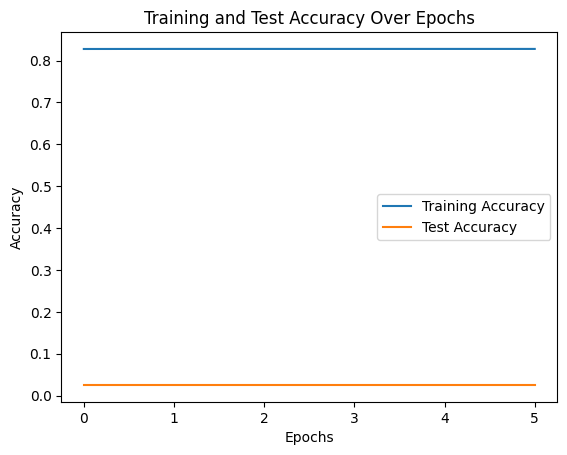

In [ ]:
num_epochs = min(len(train_accuracies), len(test_accuracies))

plt.figure()
plt.plot(np.arange(num_epochs), train_accuracies[:num_epochs], label='Training Accuracy')
plt.plot(np.arange(num_epochs), test_accuracies[:num_epochs], label='Test Accuracy')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
model_path = "./model/cnn_transformer_model_augment.pth"
# torch.save(model.state_dict(), model_path)
# print(f"Model saved to {model_path}")

# Testing the model

In [ ]:
test_df = dataframes['mitbih_test']
print(test_df.shape)

(21892, 188)


In [ ]:
labels = {
    0.0: "N",
    1.0: "S",
    2.0: "V",
    3.0: "F",
    4.0: "Q"
}

train_df.iloc[:, -1] = train_df.iloc[:, -1].replace(labels)

x_data = train_df.iloc[:,:187]
y_label = train_df.iloc[:,-1]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_label.values.ravel())



X = x_data
X_test = np.expand_dims(X, axis=1)   
X_test_tensor = torch.tensor(X_test).float()    
y_test_tensor = torch.tensor(y).long()        

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model.eval()
correct_predictions = 0
total_predictions = 0


def test(model, test_loader, criterion, device):
    model.eval()  

    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to compute gradients during testing
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)         
            loss = criterion(output, target)
            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels


In [ ]:
criterion = torch.nn.CrossEntropyLoss()  

epoch_loss, epoch_acc, all_preds, all_labels = test(model, test_loader, criterion, device)
print(f"Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_acc:.4f}")

Test Loss: 0.6581, Test Accuracy: 0.8277
